### Install packages

In [ ]:
!pip install onnx onnxruntime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!git clone https://github.com/onnx/onnx-tensorflow.git && cd onnx-tensorflow && pip install -e .

fatal: destination path 'onnx-tensorflow' already exists and is not an empty directory.


### Train model on MNIST with Pytorch


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from enum import Enum
import shutil
import time
import numpy as np

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.optim as optim

In [ ]:
class Summary(Enum):
    NONE = 0
    AVERAGE = 1
    SUM = 2
    COUNT = 3


class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, name, fmt=':f', summary_type=Summary.AVERAGE):
        self.name = name
        self.fmt = fmt
        self.summary_type = summary_type
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)

    def summary(self):
        fmtstr = ''
        if self.summary_type is Summary.NONE:
            fmtstr = ''
        elif self.summary_type is Summary.AVERAGE:
            fmtstr = '{name} {avg:.3f}'
        elif self.summary_type is Summary.SUM:
            fmtstr = '{name} {sum:.3f}'
        elif self.summary_type is Summary.COUNT:
            fmtstr = '{name} {count:.3f}'
        else:
            raise ValueError('invalid summary type %r' % self.summary_type)

        return fmtstr.format(**self.__dict__)


class ProgressMeter(object):
    def __init__(self, num_batches, meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def display(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        print('\t'.join(entries))

    def display_summary(self):
        entries = [" *"]
        entries += [meter.summary() for meter in self.meters]
        print(' '.join(entries))

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'


In [ ]:
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res


In [ ]:
transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])

In [ ]:
ds_train = datasets.MNIST('./data', train=True, download=True,
                       transform=transform)

In [ ]:
ds_valid = datasets.MNIST('./data', train=False,
                       transform=transform)

In [ ]:
print(ds_train.class_to_idx)

{'0 - zero': 0, '1 - one': 1, '2 - two': 2, '3 - three': 3, '4 - four': 4, '5 - five': 5, '6 - six': 6, '7 - seven': 7, '8 - eight': 8, '9 - nine': 9}


In [ ]:
train_loader = DataLoader(ds_train,batch_size = 50,shuffle = True,num_workers=2)
val_loader = DataLoader(ds_valid,batch_size = 50,shuffle = True,num_workers=2)

#### Check loaded MNIST image examples

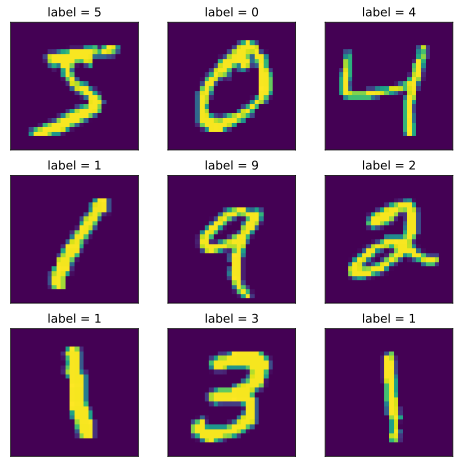

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

#查看部分样本
from matplotlib import pyplot as plt 

plt.figure(figsize=(8,8)) 
for i in range(9):
    img,label = ds_train[i]
    img = img.permute(1,2,0)
    ax=plt.subplot(3,3,i+1)
    ax.imshow(img.numpy().squeeze(axis=2))
    ax.set_title("label = %d"%label)
    ax.set_xticks([])
    ax.set_yticks([]) 
plt.show()

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        # self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        # self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(5408, 128)
        # self.fc2 = nn.Linear(128, 10)


    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        # x = self.conv2(x)
        # x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        # x = F.relu(x)
        # x = self.dropout2(x)
        # x = self.fc2(x)
#         output = F.log_softmax(x, dim=1)
        return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
model = Net().to(device)

In [ ]:
print(model)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=5408, out_features=10, bias=True)
)


In [ ]:
epochs = 5
print_freq = 500

In [ ]:
optimizer = optim.Adadelta(model.parameters(), lr=0.1)
#torch.optim.SGD(model.parameters(), lr=0.01,momentum=0.9,weight_decay=1e-4)
criterion = nn.CrossEntropyLoss().to(device)

In [ ]:
def train(train_loader, model, criterion, optimizer, epoch):
    batch_time = AverageMeter('Time', ':6.3f')
    data_time = AverageMeter('Data', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    progress = ProgressMeter(
        len(train_loader),
        [batch_time, data_time, losses, top1],
        prefix="Epoch: [{}]".format(epoch))

    # switch to train mode
    model.train()

    end = time.time()
    for i, (images, target) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        target = target.to(device)
        # compute output
        output = model(images)

        loss = criterion(output, target)

        # measure accuracy and record loss
        acc1 = accuracy(output, target, topk=(1,))
        losses.update(loss.item(), images.size(0))
        top1.update(acc1[0].item(), images.size(0))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % print_freq == 0:
            progress.display(i)

In [ ]:
def validate(val_loader, model, criterion):
    batch_time = AverageMeter('Time', ':6.3f', Summary.NONE)
    losses = AverageMeter('Loss', ':.4e', Summary.AVERAGE)
    top1 = AverageMeter('Acc@1', ':6.2f', Summary.AVERAGE)
    progress = ProgressMeter(
        len(val_loader),
        [batch_time, losses, top1],
        prefix='Test: ')

    # switch to evaluate mode
    model.eval()

    with torch.no_grad():
        end = time.time()
        for i, (images, target) in enumerate(val_loader):
            images = images.to(device)
            target = target.to(device)
            # compute output
            output = model(images)
            loss = criterion(output, target)

            # measure accuracy and record loss
            acc1 = accuracy(output, target, topk=(1,))
            losses.update(loss.item(), images.size(0))
            top1.update(acc1[0].item(), images.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % print_freq == 0:
                progress.display(i)

        progress.display_summary()

    return top1.avg, losses.avg

In [ ]:
def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')

In [ ]:
best_acc1 = 0
best_loss1 = float('inf')
for epoch in range(epochs):

#     adjust_learning_rate(optimizer, epoch)

    # train for one epoch
    train(train_loader, model, criterion, optimizer, epoch)

    # evaluate on validation set
    acc1, loss1 = validate(val_loader, model, criterion)

    # remember best bestloss1 and save checkpoint
    is_best = loss1 < best_loss1
    best_loss1 = min(loss1, best_loss1)
    save_checkpoint({
                'epoch': epoch + 1,
                'state_dict': model.state_dict(),
                'best_loss1': best_loss1,
                'optimizer': optimizer.state_dict(),
            }, is_best)

Epoch: [0][   0/1200]	Time  0.141 ( 0.141)	Data  0.129 ( 0.129)	Loss 4.8976e+00 (4.8976e+00)	Acc@1   0.00 (  0.00)
Epoch: [0][ 500/1200]	Time  0.011 ( 0.011)	Data  0.007 ( 0.007)	Loss 2.5521e-01 (4.6795e-01)	Acc@1  94.00 ( 87.08)
Epoch: [0][1000/1200]	Time  0.019 ( 0.010)	Data  0.017 ( 0.007)	Loss 1.2977e-01 (3.6166e-01)	Acc@1  96.00 ( 89.79)
Test: [  0/200]	Time  0.129 ( 0.129)	Loss 1.2884e-01 (1.2884e-01)	Acc@1  96.00 ( 96.00)
 *  Loss 0.183 Acc@1 94.850
Epoch: [1][   0/1200]	Time  0.147 ( 0.147)	Data  0.134 ( 0.134)	Loss 1.4367e-01 (1.4367e-01)	Acc@1  94.00 ( 94.00)
Epoch: [1][ 500/1200]	Time  0.003 ( 0.011)	Data  0.000 ( 0.007)	Loss 8.1039e-02 (1.8913e-01)	Acc@1  98.00 ( 94.56)
Epoch: [1][1000/1200]	Time  0.003 ( 0.011)	Data  0.000 ( 0.007)	Loss 8.7530e-02 (1.6998e-01)	Acc@1  96.00 ( 95.14)
Test: [  0/200]	Time  0.139 ( 0.139)	Loss 7.0238e-02 (7.0238e-02)	Acc@1  98.00 ( 98.00)
 *  Loss 0.121 Acc@1 96.530
Epoch: [2][   0/1200]	Time  0.153 ( 0.153)	Data  0.146 ( 0.146)	Loss 5.5712e-0

#### Show evaluation examples

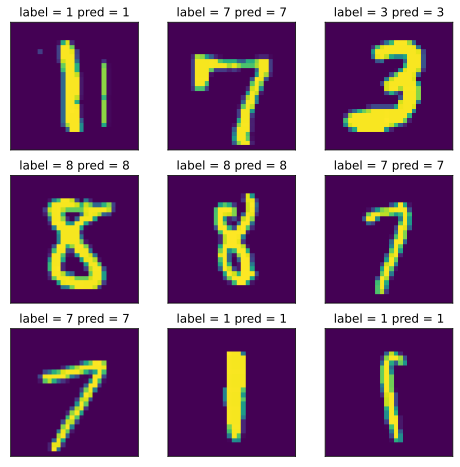

In [ ]:
model.eval()

with torch.no_grad():
    images, target = next(iter(val_loader))
    images, target = images[0:9], target[0:9]
    output = model(images.to(device)).cpu()
    
    preds = output.argmax(dim=1)
    labels = target
    imgs = images
    
plt.figure(figsize=(8,8)) 
for i in range(9):
    img,label = images[i], target[i]
    img = img.permute(1,2,0)
    ax=plt.subplot(3,3,i+1)
    ax.imshow(img.squeeze(axis=2))
    ax.set_title(f'label = {label} pred = {preds[i]}')
    ax.set_xticks([])
    ax.set_yticks([]) 
plt.show()


### Torch-ONNX-Tensorflow-TensorflowLite

In [ ]:
import onnx
from onnx_tf.backend import prepare
import tensorflow as tf

In [ ]:
def representative_dataset():
    for d in ds_valid:
      yield [d[0].numpy()]

In [ ]:
def torch2tflite(sample_input, loaded_model, onnx_model_path, tf_model_path, tflite_model_path):
#     loaded_model = torch.load(torch_model_path, map_location='cpu')
    torch_model = loaded_model.eval()
    torch.onnx.export(
        model=torch_model,
        args=sample_input,
        f=onnx_model_path, # todo
        verbose=False,
        export_params=True,
        do_constant_folding=False,
        input_names=['input'],
        opset_version=10,
        output_names=['output'])
    print('ONNX model successfully converted')
    onnx_model = onnx.load(onnx_model_path)
    onnx.checker.check_model(onnx_model)
    tf_rep = prepare(onnx_model)
    tf_rep.export_graph(tf_model_path)
    print('TensorFlow model successfully converted')
    converter = tf.lite.TFLiteConverter.from_saved_model(tf_model_path)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.representative_dataset = representative_dataset # It allows the converter to estimate a dynamic range for all the variable data.
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
    converter.inference_input_type = tf.int8 
    converter.inference_output_type = tf.int8
    tflite_model = converter.convert()
    try:
        with open(tflite_model_path, 'wb') as f:
            f.write(tflite_model)
        print('TensorFlow-lite model successfully converted')
    except Exception as e:
        print('TensorFlow-lite model unsuccessfully converted')

    
    return tflite_model

In [ ]:
samples = next(iter(val_loader))[0]

In [ ]:
sample  = torch.unsqueeze(next(iter(val_loader))[0][1], 0)

In [ ]:
torch_model_path = './model_best.pth.tar'
checkpoint = torch.load(torch_model_path, map_location='cpu')
model.load_state_dict(checkpoint['state_dict'])
print('PyTorch model successfully loaded and mapped to CPU')

PyTorch model successfully loaded and mapped to CPU


In [ ]:
tflite_model = torch2tflite(sample, model.cpu(), onnx_model_path='./model_best.onnx', tf_model_path='./model_best', tflite_model_path='./model_best.tflite')

ONNX model successfully converted
INFO:tensorflow:Assets written to: ./model_best/assets


INFO:tensorflow:Assets written to: ./model_best/assets


TensorFlow model successfully converted


TensorFlow-lite model successfully converted


### TFlite Model Inference

In [ ]:
def tflite_inference(tflite_path, image):
  '''perform batch inference on a tensorflow lite model
  '''
  # Load the TFLite model and allocate tensors.
  interpreter = tf.lite.Interpreter(model_path=tflite_path)
  # Get input and output tensors.
  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]
  interpreter.allocate_tensors()
  if input_details['dtype'] == np.int8:
    input_scale, input_zero_point = input_details["quantization"]
    image = image / input_scale + input_zero_point
  image =  torch.unsqueeze(image, 0).to(torch.int8)

  interpreter.set_tensor(input_details['index'], image)
  interpreter.invoke()
  # The function `get_tensor()` returns a copy of the tensor data.
  # Use `tensor()` in order to get a pointer to the tensor.
  output_data = interpreter.get_tensor(output_details['index'])

  return output_data

In [ ]:
tflite_inference('./model_best.tflite', samples[3]).argmax()

1

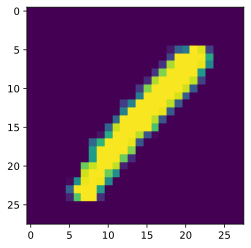

In [ ]:
plt.imshow(samples[3].permute(1,2,0).squeeze(axis=2))

### TFlite evaluation

In [ ]:
# tflite_model = tf.lite.Interpreter('./model_best.tflite')
# tflite_model.allocate_tensors()
# input_details = tflite_model.get_input_details()
# output_details = tflite_model.get_output_details()
# tflite_model.set_tensor(input_details[0]['index'], sample)
# tflite_model.invoke()
# y_pred = tflite_model.get_tensor(output_details[0]['index'])
# print(f'prediction: {y_pred.argmax()}')
# test_img_tflite = sample.squeeze(dim=0).permute(1,2,0)
# plt.imshow(test_img_tflite)

In [ ]:
# ds_valid[0][0]

In [ ]:
# images, targets = next(iter(val_loader))

In [ ]:
tflite_model = tf.lite.Interpreter('./model_best.tflite')
tflite_model.allocate_tensors()
input_details = tflite_model.get_input_details()[0]
output_details = tflite_model.get_output_details()[0]
num_correct = 0
for i, (image, target) in enumerate(ds_valid):
    if input_details['dtype'] == np.int8:
      input_scale, input_zero_point = input_details["quantization"]
      image = image / input_scale + input_zero_point
    image =  torch.unsqueeze(image, 0).to(torch.int8)
    
    tflite_model.set_tensor(input_details['index'], image)
    tflite_model.invoke()
    y_pred = tflite_model.get_tensor(output_details['index'])[0]
    num_correct += 1 if y_pred.argmax()==target else 0
    if i>=(1000-1):
        break
print(f'accuracy = {100*num_correct/1000:.2f}%')

accuracy = 97.40%


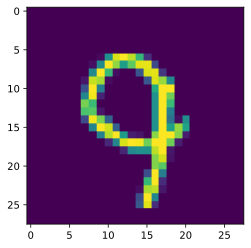

In [ ]:
plt.imshow(image.squeeze(dim=0).permute(1,2,0).squeeze(axis=2))

In [ ]:
y_pred.argmax()

9

### Batch inference

In [ ]:
def tflite_batch_inference(tflite_path, data):
  '''perform batch inference on a tensorflow lite model
  args:
    - tflite_path = pathlib.Path
    - data = np.array
    - data_type = np.dtype
  returns:
    - output_data: np.array
  '''
  # Load the TFLite model and allocate tensors.
  interpreter = tf.lite.Interpreter(model_path=tflite_path)
  # Get input and output tensors.
  input_details = interpreter.get_input_details()
  output_details = interpreter.get_output_details()

  # Adjust graph input to handle batch tensor
  interpreter.resize_tensor_input(input_details[0]['index'], data.shape)
  print(data.shape)
  # Adjust output #1 in graph to handle batch tensor
  interpreter.resize_tensor_input(output_details[0]['index'], [data.shape[0], 1])
  print( [data.shape[0], 1])
  interpreter.allocate_tensors()

  interpreter.set_tensor(input_details[0]['index'], data)
  interpreter.invoke()
  # The function `get_tensor()` returns a copy of the tensor data.
  # Use `tensor()` in order to get a pointer to the tensor.
  output_data = interpreter.get_tensor(output_details[0]['index'])

  return output_data

Note: This **does not work** because of the conversation between NCHW and NHWC is not implemented by ONNX-Tensorflow

### Export to TFlite micro model .cc


Let's convert TFLite to TFLite micro in `.CC`
If there is no `xxd` in your env, please install it.
```
!apt-get install xxd
```

In [ ]:
!apt-get install xxd

Reading package lists... Done
Building dependency tree       
Reading state information... Done
xxd is already the newest version (2:8.0.1453-1ubuntu1.8).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [ ]:
!xxd -i model_best.tflite > model_data.cc

Let's check the size of model

In [ ]:
!tail -n1 model_data.cc

unsigned int model_best_tflite_len = 696288;
